In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.2.1+cu121'

### 1. Creating non-linear data (red and blue circles)

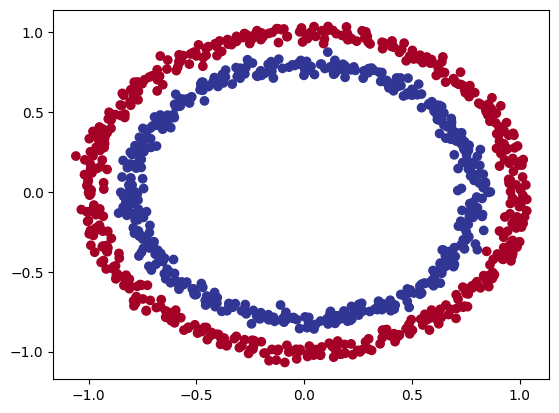

In [2]:
# Make and plot data
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [3]:
# Convert data to tensors and then to train and test splits
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 2. Building a model with non-linearity

In [4]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
# Build a model with non-linear activation functions
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_1 = CircleModel().to(device)
model_1

CircleModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [6]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=0.1)



In [7]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

### 3. Training a model with non-linearity

In [8]:
len(X_test), len(y_test)

(200, 200)

In [9]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  if epoch % 100 == 0:
    print(f'Epoch: {epoch}, Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

Epoch: 0, Loss: 0.6918, Acc: 50.00% | Test Loss: 0.6911, Test Acc: 50.00%
Epoch: 100, Loss: 0.6877, Acc: 57.75% | Test Loss: 0.6866, Test Acc: 60.50%
Epoch: 200, Loss: 0.6843, Acc: 59.00% | Test Loss: 0.6829, Test Acc: 61.50%
Epoch: 300, Loss: 0.6795, Acc: 59.88% | Test Loss: 0.6776, Test Acc: 64.00%
Epoch: 400, Loss: 0.6722, Acc: 62.62% | Test Loss: 0.6700, Test Acc: 71.00%
Epoch: 500, Loss: 0.6604, Acc: 69.50% | Test Loss: 0.6579, Test Acc: 78.00%
Epoch: 600, Loss: 0.6396, Acc: 72.00% | Test Loss: 0.6380, Test Acc: 77.00%
Epoch: 700, Loss: 0.5992, Acc: 85.88% | Test Loss: 0.6024, Test Acc: 85.50%
Epoch: 800, Loss: 0.5244, Acc: 96.25% | Test Loss: 0.5365, Test Acc: 96.00%
Epoch: 900, Loss: 0.4053, Acc: 99.50% | Test Loss: 0.4295, Test Acc: 99.50%


### 4. Evaluating a model trained with non-linear activation functions

In [10]:
# Make predictions
model_1.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_1(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

In [11]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path('helper_functions.py').is_file():
  print('helper_functions.py already exists, skipping download')
else:
  print('Downloading helper_functions.py')
  request = requests.get('https://raw.githubusercontent.com/Claudiu-Mihael-Terenche/Machine-Learning/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

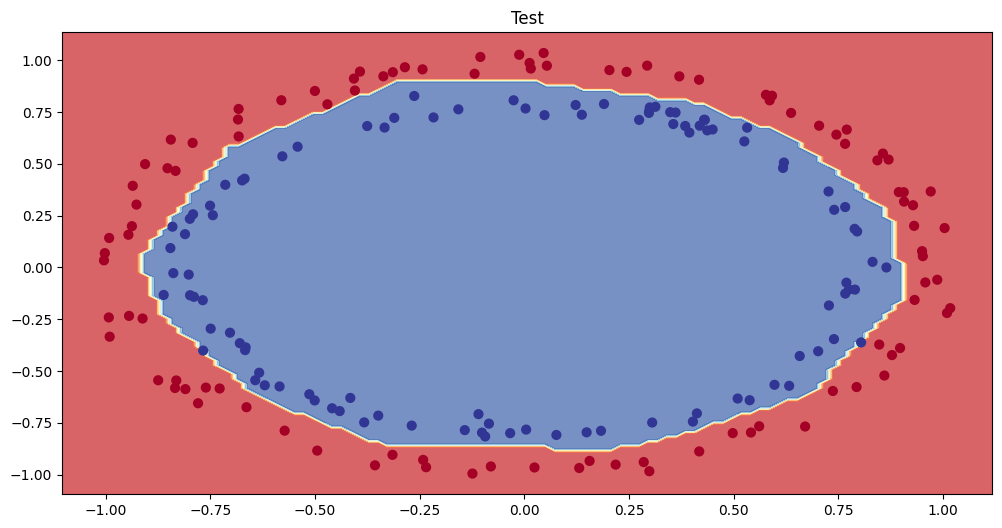

In [12]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

In [13]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [14]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

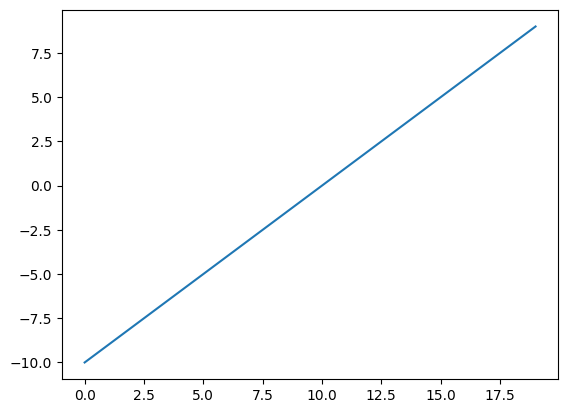

In [15]:
# Visualize the tensor
plt.plot(A);

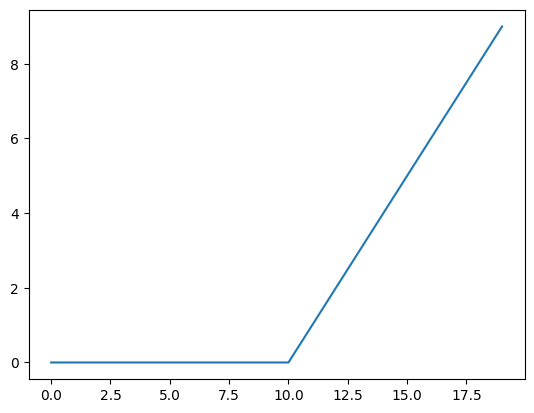

In [16]:
plt.plot(torch.relu(A));

In [17]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.max(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

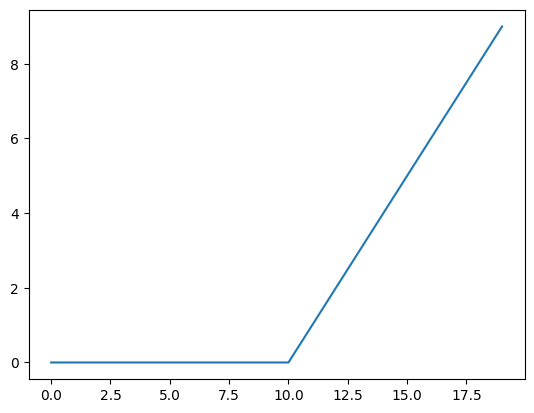

In [18]:
# Plot ReLU activation function
plt.plot(relu(A))

In [19]:
# Sigmoid = https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

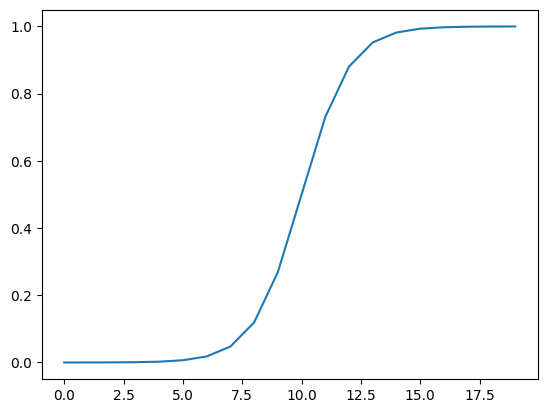

In [20]:
plt.plot(torch.sigmoid(A));

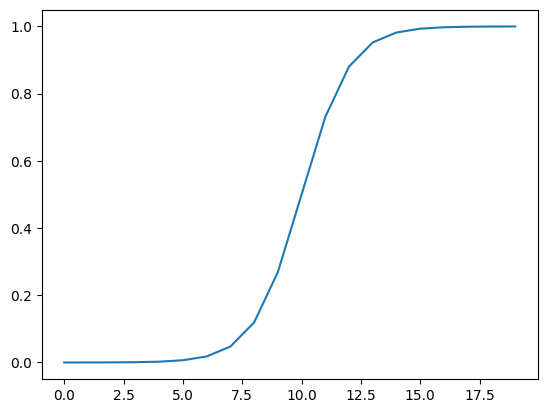

In [21]:
plt.plot(sigmoid(A));